In [1]:
import os, sys
from tqdm import trange, tqdm
from IPython.utils import io
from IPython.display import clear_output
import itertools
import pickle

import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from numba import njit

import torch
from torch import nn
from torch.utils.data import TensorDataset, ConcatDataset

source = "../source"
sys.path.append(source)

from data import fun_data, grid_data
from preprocessing import Direct, Encoding, OneHot
from compilation import Compiler, Tracker, ScalarTracker, ActivationTracker
from activations import get_activations
from data_analysis.visualization.animation import SliderAnimation
from data_analysis.visualization.activations import (
    ActivationsAnimation,
    FunctionAnimation,
    PointAnimation,
)
from data_analysis.visualization.automata import AutomatonAnimation
from data_analysis.visualization.epochs import EpochAnimation
import data_analysis.visualization.publication as publication
import simulate
import two_points

import models as models
from models import MLP, CNN, ResNet

import cProfile
import pstats


is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU available")
else:
    device = torch.device("cpu")
    print("GPU not available")

device = torch.device("cpu")

traj_path = "plots/2_points/comparisons/"

publication.set_color_mixed(1)

GPU available


In [2]:
settings = pd.read_csv("model_settings/2 points.txt", sep=" ", header=0)

In [3]:
def make_plots(setting, save=True):
    ## Load settings
    (
        model_type,
        nonlinearity,
        gain,
        lr,
        P,
        L,
        n_epochs,
        hidden_layer,
        dx2,
        dy2,
        in_dim,
        out_dim,
    ) = settings.loc[setting].to_numpy()
    model_type = getattr(models, model_type)
    if nonlinearity == "discontinuous":
        nonlinearity = simulate.Discontinuous.apply
    elif nonlinearity == "none":
        nonlinearity = None
    else:
        nonlinearity = getattr(torch.nn.functional, nonlinearity)

    threshold = 1e-4
    n_epochs_plot = 40000

    ## Load data
    def load_data(data_name):
        data_path = f"{traj_path}{data_name}.pkl"
        if os.path.exists(data_path):
            with open(data_path, "rb") as f:
                return pickle.load(f)
        else:
            return {}

    etas_h_dic, etas_y_dic, G_hs_dic, G_ys_dic = [
        load_data(name) for name in ["etas_h", "etas_y", "G_hs", "G_ys"]
    ]

    if setting in etas_h_dic.keys():
        eta_h_opts = etas_h_dic[setting]
        eta_y_opts = etas_y_dic[setting]
        G_hs = G_hs_dic[setting]
        G_ys = G_ys_dic[setting]
        print("Fit parameters succesfully loaded from previous run.")
    else:
        ## Fit effective learning rates
        print("Could not find previous fit parameters, fitting...")
        eta_h_opts, eta_y_opts = [], []
        G_hs, G_ys = [], []
        for _ in range(30):
            data, encoding = two_points.data_set(dx2, dy2, 1, 1, device)

            model = model_type(
                encoding=encoding,
                input_size=1,
                output_size=1,
                hidden_dim=P,
                n_hid_layers=L,
                device=device,
                init_std=gain,
                non_linearity=nonlinearity,
            )

            # Compute G
            input_1 = data[0][0]
            input_2 = data[0][1]
            hid_1 = model(input_1)[1][hidden_layer]
            hid_2 = model(input_2)[1][hidden_layer]
            pred_1 = model(input_1)[0]
            pred_2 = model(input_2)[0]
            input_1, input_2, hid_1, hid_2, pred_1, pred_2 = [
                a.detach().numpy()
                for a in (input_1, input_2, hid_1, hid_2, pred_1, pred_2)
            ]
            G_h = (
                np.linalg.norm(hid_2 - hid_1) ** 2
                / np.linalg.norm(input_2 - input_1) ** 2
            )
            G_y = (
                np.linalg.norm(pred_2 - pred_1) ** 2
                / np.linalg.norm(hid_2 - hid_1) ** 2
            )

            criterion = lambda x, y: 0.5 * nn.functional.mse_loss(x, y)
            optimizer = torch.optim.SGD(model.parameters(), lr=lr)
            compiler = Compiler(model, criterion, optimizer)
            compiler.trackers = {
                "loss": ScalarTracker(lambda: compiler.validation([data])),
                "hidden": ActivationTracker(
                    model,
                    lambda inputs: model(inputs)[1][hidden_layer],
                    datasets=[data],
                ),
                "output": ActivationTracker(
                    model, lambda inputs: model(inputs)[0], datasets=[data]
                ),
            }

            h0, y0, w0 = two_points.get_h_y_w(data, model, hidden_layer)

            with io.capture_output() as captured:
                compiler.training_run([data], [data], n_epochs=n_epochs, batch_size=100)

            if compiler.trackers["loss"].get_entry(-1)[0][0] > 1e-2:
                continue

            data_hid = compiler.trackers["hidden"].get_trace().copy()
            data_output = compiler.trackers["output"].get_trace().copy()
            h_A = [
                np.array(data.loc[epoch, 0, "A"])
                for epoch, data in data_hid.query("Dataset == 0").groupby("Epoch")
            ]
            h_B = [
                np.array(data.loc[epoch, 0, "B"])
                for epoch, data in data_hid.query("Dataset == 0").groupby("Epoch")
            ]
            y_A = [
                np.array(data.loc[epoch, 0, "A"])
                for epoch, data in data_output.query("Dataset == 0").groupby("Epoch")
            ]
            y_B = [
                np.array(data.loc[epoch, 0, "B"])
                for epoch, data in data_output.query("Dataset == 0").groupby("Epoch")
            ]
            epochs = np.arange(0, len(h_A))
            y_true_A, y_true_B = data[0][1].numpy(), data[1][1].numpy()
            dy2 = np.sum((y_true_B - y_true_A) ** 2)
            h2 = np.array([np.sum((h_A[epoch] - h_B[epoch]) ** 2) for epoch in epochs])
            y2 = np.array([np.sum((y_A[epoch] - y_B[epoch]) ** 2) for epoch in epochs])
            w = np.array(
                [
                    y2[epoch] - np.dot(y_true_A - y_true_B, y_A[epoch] - y_B[epoch])
                    for epoch in epochs
                ]
            )

            eta_h_opt, eta_y_opt, _ = simulate.optimize_eta(h2, y2, w, dx2, dy2)

            G_hs.append(G_h)
            G_ys.append(G_y)
            eta_h_opts.append(eta_h_opt)
            eta_y_opts.append(eta_y_opt)

        ## Save data
        datas = [eta_h_opts, eta_y_opts, G_hs, G_ys]
        data_dics = [etas_h_dic, etas_y_dic, G_hs_dic, G_ys_dic]
        data_names = ["etas_h", "etas_y", "G_hs", "G_ys"]
        for data, data_dic in zip(datas, data_dics):
            data_dic[setting] = data

        for data_dic, data_name in zip(data_dics, data_names):
            data_path = f"{traj_path}{data_name}.pkl"
            with open(data_path, "wb") as f:
                pickle.dump(data_dic, f)

    eta_h, eta_y = np.mean(eta_h_opts), np.mean(eta_y_opts)
    G_h, G_y = np.mean(G_hs), np.mean(G_ys)

    print(f"eta_h, eta_y, G_h, G_y = {eta_h}, {eta_y}, {G_h}, {G_y}")

    h0s, y0s, w0s, hs, ys, ws = [], [], [], [], [], []
    dx2s, dy2s = [], []

    N = 5
    m = 1

    print("Computing plot...")
    for dx in np.linspace(1, 2, N):
        for dy in np.linspace(0, 1, N):
            dx2 = dx**2
            dy2 = dy**2
            variables = []
            for _ in range(m):
                ## Generate data
                data, encoding = two_points.data_set(dx2, dy2, 1, 1, device)
    
                ## Instantiate model
                model = model_type(
                    encoding=encoding,
                    input_size=1,
                    output_size=1,
                    hidden_dim=P,
                    n_hid_layers=L,
                    device=device,
                    init_std=gain,
                    non_linearity=nonlinearity,
                )
    
                criterion = lambda x, y: 0.5 * nn.functional.mse_loss(x, y)
                optimizer = torch.optim.SGD(model.parameters(), lr=lr / 5)
                compiler = Compiler(model, criterion, optimizer)
                compiler.trackers = {
                    "loss": ScalarTracker(lambda: compiler.validation([data]))
                }
    
                h0, y0, w0 = two_points.get_h_y_w(data, model, hidden_layer)
    
                ## Training run
                with io.capture_output() as captured:
                    compiler.training_run(
                        [data],
                        [],
                        n_epochs=n_epochs_plot,
                        batch_size=100,
                        conv_thresh=threshold,
                    )

                if compiler.trackers["loss"].get_entry(-1)[0][0] > 1e-2:
                    break
    
                h, y, w = two_points.get_h_y_w(data, model, hidden_layer)
    
                variables.append([h0, y0, w0, h, y, w])
    
            if len(variables) > 0:
                variables = np.mean(np.array(variables), axis=0)
                for i, array in enumerate((h0s, y0s, w0s, hs, ys, ws)):
                    array.append(variables[i])
                dx2s.append(dx2)
                dy2s.append(dy2)
    
                clear_output(wait=True)

                publication.set_color_mixed()
                A_low = np.sqrt(eta_h / eta_y) * np.sqrt(dy2s) * np.sqrt(dx2s)
                A_high = (
                    np.array(h0s) / np.array(dx2s)
                    - np.array(y0s) / np.array(h0s) * eta_h / eta_y
                ) * np.array(dx2s)
                h_theory = 0.5 * A_high + np.sqrt(0.25 * A_high**2 + A_low**2)
                fig = plt.figure(figsize=(2.5, 2.5))
                plt.scatter(h_theory, hs)
                plt.xlabel("$||dh(\infty)||^2$ (Theory)")
                plt.ylabel("$||dh(\infty)||^2$")
                plt.ylim(0, 1.1 * max(hs))
                plt.xlim(0)
                plt.scatter(-1,-1)
                plt.plot(np.sort(h_theory), np.sort(h_theory), linestyle="--", color="0.6",zorder=0)
                publication.plt_show()

    ## Plot theory
    publication.set_color_mixed()
    A_low = np.sqrt(eta_h / eta_y) * np.sqrt(dy2s) * np.sqrt(dx2s)
    A_high = (
        np.array(h0s) / np.array(dx2s)
        - np.array(y0s) / np.array(h0s) * eta_h / eta_y
    ) * np.array(dx2s)
    h_theory = 0.5 * A_high + np.sqrt(0.25 * A_high**2 + A_low**2)
    fig = plt.figure(figsize=(2.5, 2.5))
    plt.scatter(h_theory, hs)
    plt.xlabel("$||dh(\infty)||^2$ (Theory)")
    plt.ylabel("$||dh(\infty)||^2$")
    plt.ylim(0, 1.1 * max(hs))
    plt.xlim(0)
    publication.plt_show(
        save_path=traj_path + "dh_vs_theory_" + setting + ".png",
    )

    ## Plot theory with line
    publication.set_color_mixed()
    A_low = np.sqrt(eta_h / eta_y) * np.sqrt(dy2s) * np.sqrt(dx2s)
    A_high = (
        np.array(h0s) / np.array(dx2s)
        - np.array(y0s) / np.array(h0s) * eta_h / eta_y
    ) * np.array(dx2s)
    h_theory = 0.5 * A_high + np.sqrt(0.25 * A_high**2 + A_low**2)
    fig = plt.figure(figsize=(2.5, 2.5))
    plt.scatter(h_theory, hs)
    plt.xlabel("$||dh(\infty)||^2$ (Theory)")
    plt.ylabel("$||dh(\infty)||^2$")
    plt.ylim(0, 1.1 * max(hs))
    plt.xlim(0)
    plt.scatter(-1,-1)
    plt.plot(np.sort(h_theory), np.sort(h_theory), linestyle="--", color="0.6",zorder=0)
    publication.plt_show(
        save_path=traj_path + "dh_vs_theory_line_" + setting + ".png",
    )

    ## Plot dx
    fig = plt.figure(figsize=(2.5, 2.5))
    plt.scatter(np.array(dx2s), hs)
    plt.xlabel("$||x_2-x_1||^2$")
    plt.ylabel("$||dh(\infty)||^2$")
    plt.ylim(0, 1.1 * max(hs))
    plt.xlim(0)
    publication.plt_show(
        save_path=traj_path + "dh_vs_x_" + setting + ".png",
    )

    ## Plot dy
    fig = plt.figure(figsize=(2.5, 2.5))
    plt.scatter(np.array(dy2s), hs)
    plt.xlabel("$||y_2-y_1||^2$")
    plt.ylabel("$||dh(\infty)||^2$")
    plt.ylim(0, 1.1 * max(hs))
    plt.xlim(0)
    publication.plt_show(
        save_path=traj_path + "dh_vs_y_" + setting + ".png",
    )

    ## Plot h0
    fig = plt.figure(figsize=(2.5, 2.5))
    plt.scatter(np.array(h0s), hs)
    plt.xlabel("$||dh(0)||^2$")
    plt.ylabel("$||dh(\infty)||^2$")
    plt.ylim(0, 1.1 * max(hs))
    plt.xlim(0)
    publication.plt_show(
        save_path=traj_path + "dh_vs_h0_" + setting + ".png",
    )

    ## Plot y0
    fig = plt.figure(figsize=(2.5, 2.5))
    plt.scatter(np.array(y0s), hs)
    plt.xlabel("$||dy(0)||^2$")
    plt.ylabel("$||dh(\infty)||^2$")
    plt.ylim(0, 1.1 * max(hs))
    plt.xlim(0)
    publication.plt_show(
        save_path=traj_path + "dh_vs_y0_" + setting + ".png",
    )

    return eta_h_opts, eta_y_opts, G_hs, G_ys

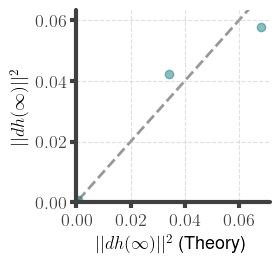

Training:  10%|█         | 2036/20000 [01:05<09:20, 32.04steps/s, train_loss=0.01357, val_loss=0.01357]

In [ ]:
etas_h, etas_y, G_hs, G_ys = {}, {}, {}, {}
for setting in settings.index:
    print(f"\t\t\t\t\t-----{setting.upper()}-----")
    eta_h_opts, eta_y_opts, G_h, G_y = make_plots(setting, save=True)